# Testing regularization of likelihood functions

In [1]:
%pylab inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
from matplotlib.colors import LogNorm

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import add_arg_scope
import tensorflow_hub as hub


In [6]:
# ndim = 2
# xx = np.arange(6).reshape(3, 2)
# print(xx)
# print()
# base = []
# for i in range(ndim):
#     tmp = np.zeros(ndim).astype(int)
#     tmp[i] = 1
#     base.append(list(tmp))

# mm = [base for i in range(4)]
# mm = np.concatenate(mm)
# print(mm)
# xx = np.expand_dims(xx, -1)
# np.squeeze(np.matmul(mm, xx))
# # np.squeeze(np.matmul(xx, mm))
# ############3
# xx = np.arange(6).reshape(3, 2)
# mm = np.zeros((ndim, 4*ndim))
# print(mm)
# for i in range(ndim):
#     mm[i][i::ndim] = 1
# print(mm)

# yy = []
# for ii in xx:
# #     yy.append(np.matmul(mm, ii))
#     yy.append(np.matmul(ii, mm))
# np.array(yy)

## Creating the forward model

In [43]:
ndim = 2
data_size = 20000
means = np.array([2., 4.]).astype('float32')
stddevs = np.array([10.,10.]).astype('float32')

seed(12345)
npA = randn(2,16)
npB = randn(16,8)
npB2 = randn(8,32)
npC = randn(32,1)

tf.reset_default_graph()

def module_fn():
    '''Define network here'''
    x = tf.placeholder(tf.float32, shape=[None, ndim], name='input')

    # Defining the forward model
    # This is the linear operator
    A = tf.constant(npA, dtype=tf.float32) 
    xx = tf.matmul(x, A)
    xx = tf.nn.tanh(xx)
    xx = xx**3
    A = tf.constant(npB, dtype=tf.float32) 
    xx = tf.matmul(xx, A)
    xx = xx**2 - xx
    
    A = tf.constant(npB2, dtype=tf.float32) 
    xx = tf.matmul(xx, A)
    xx = tf.nn.tanh(xx)
    
    A = tf.constant(npC, dtype=tf.float32) 
    xx = tf.matmul(xx, A)

    l = tf.reduce_sum(xx, axis=1)
    l = tf.nn.softplus(l)
    p = tfd.Poisson(rate=l)
    y = tf.reshape(p.sample(), (-1,))

    hub.add_signature(inputs={'input':x}, 
                          outputs={'sample':y, 'lograte':l, 'transform':A})

    
#####                                                                                                                                                                                                                                                                                     

spec = hub.create_module_spec(module_fn)
module = hub.Module(spec, trainable=True)

# Defining probabilistic forward model
prior = tfd.Normal(loc=means, scale=stddevs)
x = prior.sample(data_size)
l = module({'input':x}, as_dict=True)['lograte']
y = module({'input':x}, as_dict=True)['sample']
A = module({'input':x}, as_dict=True)['transform']


sess = tf.Session()
sess.run(tf.global_variables_initializer())
sx, sy, sl, AA = sess.run([x, y, l, A])




INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [44]:
%%bash
ls ./modules/
rm -r ./modules/fwdmodel/


densemodule
fwdmodel
specdensemodule


In [45]:
module.export('./modules/fwdmodel', sess)


INFO:tensorflow:Exported TF-Hub module to: ./modules/fwdmodel


/home/chmodi/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


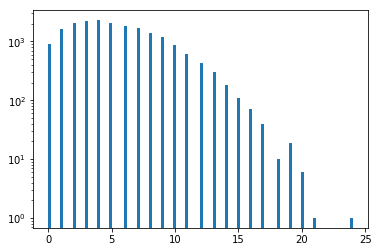

In [46]:
plt.hist(sy, bins=100, normed=False, log=True)
plt.show()

In [47]:
sl.max(), sy.max()

(13.624984, 24.0)

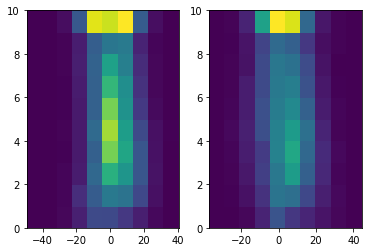

In [48]:
subplot(121)
# hist2d(sx[:,0], sy);
hist2d(sx[:,0], clip(sy.flatten(),0,10));
subplot(122)
# hist2d(sx[:,1], sy);
hist2d(sx[:,1], clip(sy.flatten(),0,10));

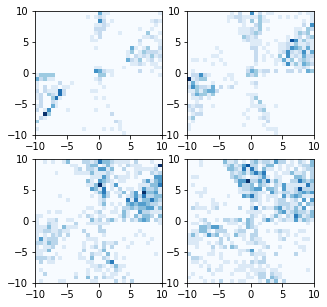

In [49]:
# Have a look at the posterior on x for a given outcome y
figure(figsize=(5,5))
rrange =[[-10,10],[-10,10]]
for i in range(4):
    subplot(2,2,i+1)
    m = (sy == i)
    hist2d(sx[:,0][m], sx[:,1][m],32,range=rrange,normed=True, cmap='Blues')

In [18]:
# Now, let's try to train a neural network to model the likelihood function

# Module

Train a neural network in a module 

In [50]:
tf.reset_default_graph()

nsize = 512

def module_fn():
    '''Define network here'''
    x = tf.placeholder(tf.float32, shape=[None, ndim], name='input')
    y = tf.placeholder(tf.float32, shape=[None], name='output')

    reg = tf.contrib.layers.l2_regularizer(0.001)

    net = tf.layers.dense(x,nsize, activation=tf.nn.leaky_relu, kernel_regularizer=reg)
    net = net + tf.layers.dense(net,nsize, activation=tf.nn.leaky_relu, kernel_regularizer=reg)
    net = net + tf.layers.dense(net,nsize, activation=tf.nn.leaky_relu, kernel_regularizer=reg)
    net = tf.layers.dense(net,1, activation=tf.nn.softplus, name='rate')
    out_prob = tfd.Poisson(rate=net, name='out_prob')
#     net = tf.layers.dense(net,1, name='lograte')
#     out_prob = tfd.Poisson(log_rate=net, name='out_prob')
    
    loglik = out_prob.log_prob(tf.expand_dims(y, axis=-1))
    sample = out_prob.sample(name='prediction')
    #
    # 
    inputs = dict(input=x, label=y)
    outputs = dict(default=net, loglik=loglik, prediction=sample)
    hub.add_signature(inputs={'features':x, 'labels':y}, 
                          outputs={'sample':sample, 'loglikelihood':loglik, 'rate':net})
    
#####                                                                                                                                                                                                                                                                                     


spec = hub.create_module_spec(module_fn)
module = hub.Module(spec, trainable=True)


xx = tf.placeholder(tf.float32, shape=[None, ndim], name='input')
yy = tf.placeholder(tf.float32, shape=[None], name='input')
rate = module({'features':xx, 'labels':yy}, as_dict=True)['rate']
loglik = module({'features':xx, 'labels':yy}, as_dict=True)['loglikelihood']
sample = module({'features':xx, 'labels':yy}, as_dict=True)['sample']
loss = -tf.reduce_mean(loglik)


lr = tf.placeholder(tf.float32)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses =[]

batch_size = 100

for i in range(5000):
    inds = np.random.randint(0, data_size, batch_size)
    l,_= sess.run([loss, train_op], feed_dict={xx:sx[inds], yy:sy[inds], lr:0.001})
    losses.append(l)
    if i%1000 ==0: print(l)
for i in range(5000):
    inds = np.random.randint(0, data_size, batch_size)
    l,_= sess.run([loss, train_op], feed_dict={xx:sx[inds], yy:sy[inds], lr:0.0005})
    losses.append(l)
    if i%1000 ==0: print(l)
pred = sess.run(sample, feed_dict={xx:sx})


# xx = tf.placeholder(tf.float32, shape=[None, ndim], name='input')
# rate = module({'features':xx, 'labels':sy}, as_dict=True)['rate']
# loglik = module({'features':xx, 'labels':sy}, as_dict=True)['loglikelihood']
# sample = module({'features':xx, 'labels':sy}, as_dict=True)['sample']
# loss = -tf.reduce_mean(loglik)


# optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
# train_op = optimizer.minimize(loss)

# sess = tf.Session()
# sess.run(tf.global_variables_initializer())
# losses =[]

# for i in range(2000):
#     l,_= sess.run([loss, train_op], feed_dict={xx:sx})
#     losses.append(l)
# pred = sess.run(sample, feed_dict={xx:sx})



# module.export('./densemodule', sess)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
7.223425
2.513785
2.2669916
2.3922007
2.2122002
2.5231133
2.1846764
2.4210453
2.3008833
2.3302834


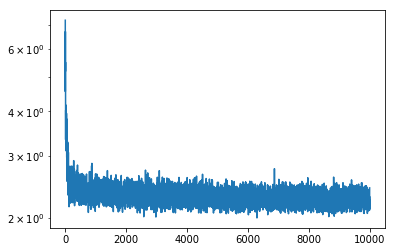

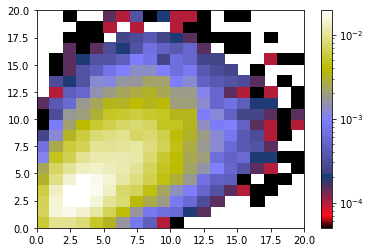

In [51]:

plot(losses)
plt.yscale('log')
plt.show()
plt.hist2d(pred[:,0],sy,20,range=[[0,20],[0,20]],cmap='gist_stern', normed=True, norm=LogNorm());
# plt.hist2d(pred[:,0],sy,20,range=[[0,20],[0,20]],cmap='gist_stern');
plt.colorbar()
plt.show()

In [52]:
%%bash
ls modules/
rm -r ./modules/densemodule


densemodule
fwdmodel
specdensemodule


In [53]:
module.export('./modules/densemodule', sess)


INFO:tensorflow:Exported TF-Hub module to: ./modules/densemodule


# Reconstruct here

In [54]:

def dorecon(yy, xinit, modname, useprior=True, niter=5000, lr=0.001):
    tf.reset_default_graph()
    module = hub.Module(modname, trainable=False)

    xrecon = tf.get_variable('xrecon',
                             initializer=xinit, 
                             trainable=True)

    loglik = -module({'features':xrecon, 'labels':yy}, as_dict=True)['loglikelihood']
#     prior = tf.square(tf.add(xrecon, -means))
    prior = tf.square(xrecon)
    prior = tf.multiply(prior, stddevs**-2)
    prior = tf.reduce_sum(prior, axis=-1, keepdims=True)
    if useprior: loss = tf.add(loglik, prior)
    else: loss = loglik
#   
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
    opt_op = optimizer.minimize(loss, var_list=[xrecon])


    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        xinit = sess.run(xrecon)
        losses = []
        priors = []
        for it in range(niter+1):
            _, l, p = sess.run([opt_op, loss, prior])
            losses.append(l)
            priors.append(p)
        xfin = sess.run(xrecon)
        
    return xfin, losses, priors

In [55]:
tf.reset_default_graph()
modname = './modules/densemodule/'
xfins = []
losses = []
priors = []
xinit = []

for i in range(6):
    ii = 2*i
    seed(100)
    yy = ii* ones((512)).astype('float32')
    xi = 5*randn(512,2)
    xi = xi.astype('float32')
    recons = dorecon(yy, xi, modname, useprior=True, niter=4000, lr=0.01)
    xfin = np.squeeze(recons[0])
    xfins.append(xfin)
    losses.append(np.squeeze(recons[1]))
    priors.append(np.squeeze(recons[2]))
    xinit.append(xi)



INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


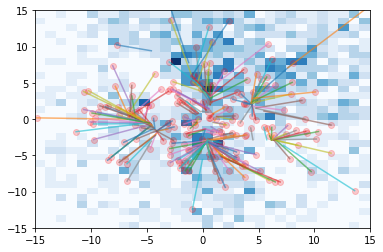

In [56]:
# With prior
i=2
ii = 2*i
m = (sy == ii)
hist2d(sx[:,0][m], sx[:,1][m],
                    32,range=[[-15,15],[-15,15]],normed=True, cmap='Blues') ;
plot([xinit[i][:200,0],xfins[i][:200,0]], [xinit[i][:200,1],xfins[i][:200,1]],alpha=0.6);
scatter(xinit[i][:200,0], xinit[i][:200,1],alpha=0.2, color='r');

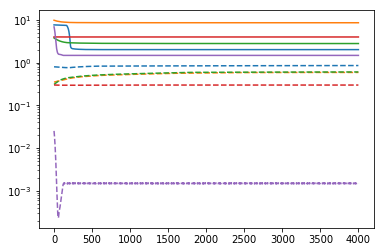

In [57]:
i = 0
# for ii in np.random.randint(0, 512, 5):
for ii in range(5):
    plt.plot(np.squeeze(np.array(losses[i])[:, ii]), 'C%d'%(ii%9))
    plt.plot(np.squeeze(np.array(priors[i])[:, ii]), 'C%d--'%(ii%9))
plt.yscale('log')
plt.show()


0 895
2 2076
4 2298
6 1864


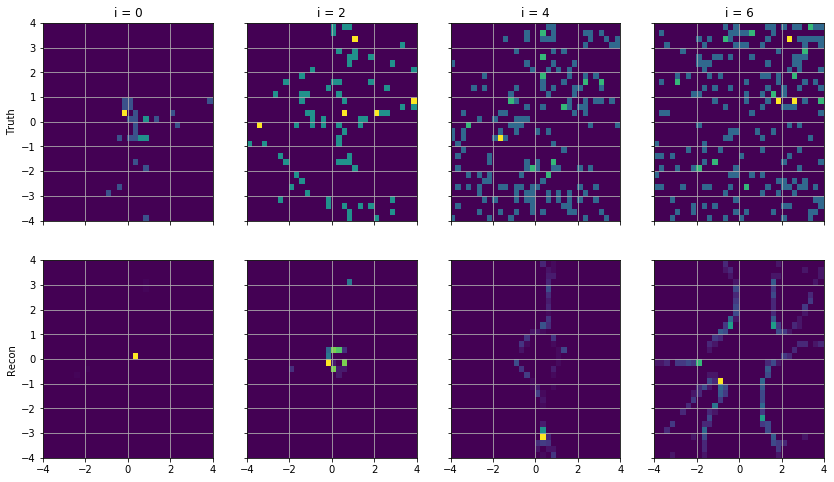

In [58]:
fig, ax = plt.subplots(2,4, figsize=(14, 8), sharex=True, sharey=True)
for i in range(4):
    ii = 2*i
    m = (sy == ii)
    print(ii, m.sum())
    ax[0, i].hist2d(sx[:,0][m], sx[:,1][m],
                    32,range=[[-4,4],[-4,4]],normed=True)
    ax[1, i].hist2d(xfins[i].T[0].flatten(), xfins[i].T[1].flatten(),
                    32, range=[[-4,4],[-4,4]],normed=True)
    ax[0, i].set_title('i = %d'%ii)
    ax[0, 0].set_ylabel('Truth')
    ax[1, 0].set_ylabel('Recon')
    
for axis in ax.flatten(): axis.grid(which='both')
    # plt.colorbar()


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


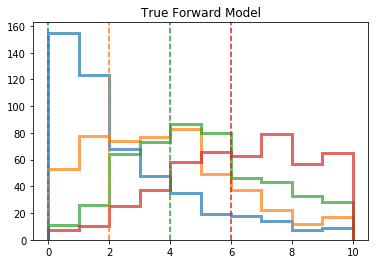

In [59]:
tf.reset_default_graph()

fwmodule = hub.Module('./modules/fwdmodel/')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(4):
        samples = fwmodule({'input':xfins[i]}, as_dict=True)['sample']
        samples = sess.run(samples)
        plt.hist(samples, alpha=0.7, range=(0, 10), bins=10, color='C%d'%i, histtype='step', lw=3)
        plt.axvline(2*i, color='C%d'%i, ls="--")
    plt.title('True Forward Model')

In [60]:
# for i in range(3):
#     rates = np.array([np.matmul(i, AA) for i in xfins[i]]).sum(axis=1)
#     plt.hist(np.random.poisson(np.exp(rates)), alpha=0.7, range=(0, 10), bins=10, color='C%d'%i)
#     plt.axvline(2*i, color='C%d'%i)
#     plt.title('True Forward Model')

# Custom dense layer

In [61]:
import sys
sys.path.append('../../utils/')
import tfops, layers
from layers import SpecDenseLayer

In [62]:
# xx = np.arange(6).reshape(3, 2)
# np.concatenate([xx]* 4, axis=1)
# np.tile(xx, 4)

In [63]:
nsize = 512
repeats = nsize //ndim
print(repeats)

mm = np.zeros((ndim, repeats*ndim)).astype('float32')
for i in range(ndim):
    mm[i][i::ndim] = 1

    
tf.reset_default_graph()


def module_fn():
    '''Define network here'''
    x = tf.placeholder(tf.float32, shape=[None, ndim], name='input')
    y = tf.placeholder(tf.float32, shape=[None], name='output')
    
    
# #     resizem = tf.constant(mm)
# #     inp = tf.matmul(x, mm)
#     inp = tf.tile(x, [1, repeats])
#     net = inp + SpecDenseLayer(nsize, activation=tf.nn.leaky_relu)(inp)

    net = SpecDenseLayer(nsize, activation=tf.nn.leaky_relu)(x)
    net = net + SpecDenseLayer(nsize, activation=tf.nn.leaky_relu)(net)
    net = net + SpecDenseLayer(nsize, activation=tf.nn.leaky_relu)(net)
    net = SpecDenseLayer(1, activation=tf.nn.softplus)(net)
    out_prob = tfd.Poisson(rate=net, name='out_prob')
#     net = SpecDenseLayer(1)(net)
#     out_prob = tfd.Poisson(log_rate=net, name='out_prob')

    loglik = out_prob.log_prob(tf.expand_dims(y, axis=-1))
    sample = out_prob.sample(name='prediction')
    #
    # 
    inputs = dict(input=x, label=y)
    outputs = dict(default=net, loglik=loglik, prediction=sample)
    hub.add_signature(inputs={'features':x, 'labels':y}, 
                          outputs={'sample':sample, 'loglikelihood':loglik, 'rate':net})
    
#####                                                                                                                                                                                                                                                                                     

spec = hub.create_module_spec(module_fn)
module = hub.Module(spec, trainable=True)

xx = tf.placeholder(tf.float32, shape=[None, ndim], name='input')
yy = tf.placeholder(tf.float32, shape=[None], name='input')
rate = module({'features':xx, 'labels':yy}, as_dict=True)['rate']
loglik = module({'features':xx, 'labels':yy}, as_dict=True)['loglikelihood']
sample = module({'features':xx, 'labels':yy}, as_dict=True)['sample']
loss = -tf.reduce_mean(loglik)


lr = tf.placeholder(tf.float32)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses =[]

batch_size = 100

for i in range(5000):
    inds = np.random.randint(0, data_size, batch_size)
    l,_= sess.run([loss, train_op], feed_dict={xx:sx[inds], yy:sy[inds], lr:0.001})
    losses.append(l)
    if i%1000 ==0: print(l)
for i in range(5000):
    inds = np.random.randint(0, data_size, batch_size)
    l,_= sess.run([loss, train_op], feed_dict={xx:sx[inds], yy:sy[inds], lr:0.0005})
    losses.append(l)
    if i%1000 ==0: print(l)
pred = sess.run(sample, feed_dict={xx:sx})




256


../../utils/tfops.py:35: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
../../utils/tfops.py:35: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
../../utils/tfops.py:35: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
../../utils/tfops.py:35: UserWarning: Setting update_collection 

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
12.427569
2.4764564
2.3024457
2.5406814
2.32941
2.4429834
2.3457835
2.4920602
2.2806807
2.5846372


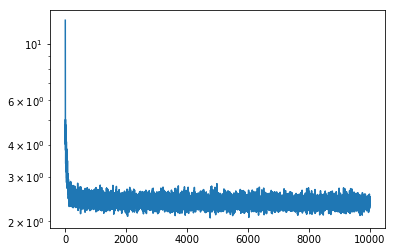

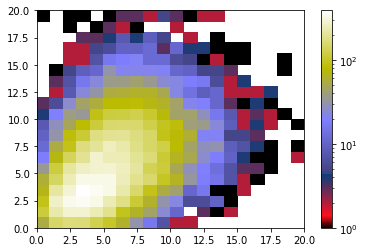

In [64]:
plot(losses)
plt.yscale('log')
plt.show()
# hist2d(pred[:,0],sy,20,range=[[0,20],[0,20]],cmap='gist_stern');
plt.hist2d(pred[:,0],sy,20,range=[[0,20],[0,20]],cmap='gist_stern', norm=LogNorm());
plt.colorbar()
plt.show()

In [65]:
%%bash
ls ./modules/
rm -r ./modules/specdensemodule


densemodule
fwdmodel
specdensemodule


In [66]:
module.export('./modules/specdensemodule', sess)


INFO:tensorflow:Exported TF-Hub module to: ./modules/specdensemodule


In [67]:
tf.reset_default_graph()
modname = './modules/densemodule/'
module = hub.Module(modname, trainable=False)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    kern = sess.run(tf.get_collection('variables')[2])

tf.reset_default_graph()
modname = './modules/specdensemodule/'
module = hub.Module(modname, trainable=False)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    var = tf.get_collection('variables')[3]
    print(var)
    kernspec = sess.run(var)
# tf.get_collection('variables')


<tf.Variable 'module/spec_dense_layer_1//kernelspecnorm/kernel:0' shape=(512, 512) dtype=float32>


In [68]:
tf.get_collection('variables');


In [69]:
kernspec.shape

(512, 512)

In [70]:
def poweriter(mat):
    u = np.random.normal(size=mat.shape[-1])
    for i in range(100):
        v = np.matmul(u, mat.T)
        v = v/np.linalg.norm(v)
        u = np.matmul(v, mat)
        u = u/np.linalg.norm(u)

    return np.matmul(np.matmul(v, mat), np.transpose(u))


poweriter(kern) , poweriter(kernspec)

(9.357047052353156, 8.165485779052636)

## recon again 

In [71]:
tf.reset_default_graph()
modname = './modules/specdensemodule/'
xfinsspec = []
losses = []
xinitspec = []

for i in range(6):
    ii = 2*i
    seed(100)
    yy = ii* ones((512)).astype('float32')
    xi = 5*randn(512,2)
    xi = xi.astype('float32')
    recons = dorecon(yy, xi, modname, useprior=True, niter=4000, lr=0.01)
    xfin = np.squeeze(recons[0])
    xfinsspec.append(xfin)
    losses.append(np.squeeze(recons[1]))
    priors.append(np.squeeze(recons[2]))
    xinitspec.append(xi)



INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


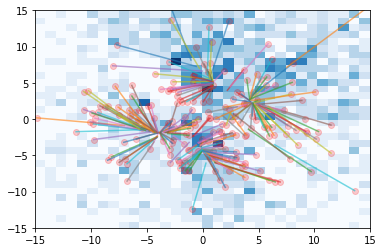

In [72]:
# With prior
i=2
ii = 2*i
m = (sy == ii)
hist2d(sx[:,0][m], sx[:,1][m],
                    32,range=[[-15,15],[-15,15]],normed=True, cmap='Blues') ;
plot([xinitspec[i][:200,0],xfinsspec[i][:200,0]], 
     [xinitspec[i][:200,1],xfinsspec[i][:200,1]],alpha=0.6);

scatter(xinitspec[i][:200,0], xinitspec[i][:200,1],alpha=0.2, color='r');

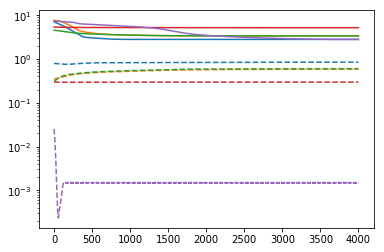

In [73]:
i = 0
# for ii in np.random.randint(0, 512, 5):
for ii in range(5):
    plt.plot(np.squeeze(np.array(losses[i])[:, ii]), 'C%d'%(ii%9))
    plt.plot(np.squeeze(np.array(priors[i])[:, ii]), 'C%d--'%(ii%9))
plt.yscale('log')
plt.show()


0 895
2 2076
4 2298
6 1864
8 1420
10 882


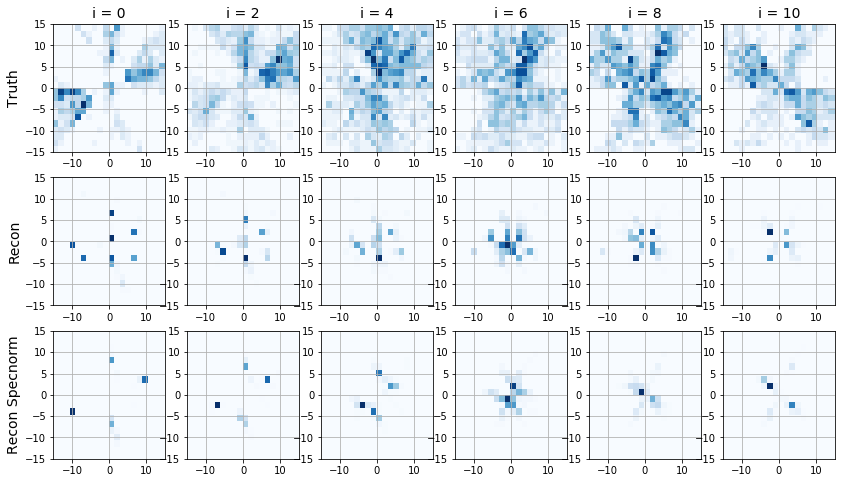

In [89]:
fsize = 14
rrange = [[-15,15],[-15,15]]
bins = 20

fig, ax = plt.subplots(3,6, figsize=(14, 8), sharex=False, sharey=False)
for i in range(6):
    ii = 2*i
    m = (sy == ii)
    print(ii, m.sum())
    ax[0, i].hist2d(sx[:,0][m], sx[:,1][m],
                    bins=bins, range=rrange, normed=True, cmap='Blues') ;
#                     bins,range=[[-4,4],[-4,4]],normed=True, norm=LogNorm())
    ax[1, i].hist2d(xfins[i].T[0].flatten(), xfins[i].T[1].flatten(),
                    bins=bins, range=rrange, normed=True, cmap='Blues') ;
    ax[2, i].hist2d(xfinsspec[i].T[0].flatten(), xfinsspec[i].T[1].flatten(),
                    bins=bins, range=rrange, normed=True, cmap='Blues') ;

    ax[0, i].set_title('i = %d'%ii, fontsize=fsize)
    ax[0, 0].set_ylabel('Truth', fontsize=fsize)
    ax[1, 0].set_ylabel('Recon', fontsize=fsize)
    ax[2, 0].set_ylabel('Recon Specnorm', fontsize=fsize)
    
for axis in ax.flatten(): axis.grid(which='both')
    # plt.colorbar()


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


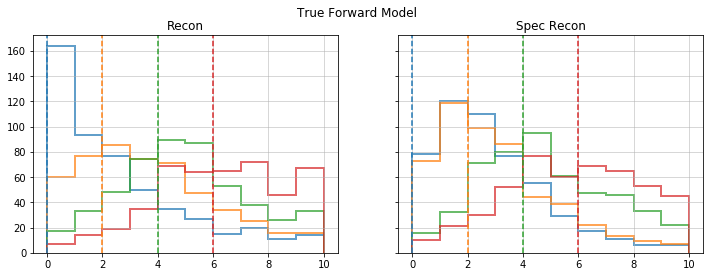

In [75]:
tf.reset_default_graph()

fwmodule = hub.Module('./modules/fwdmodel/')

rrange = [0, 10]
bins = 10

fig, axar = plt.subplots(1, 2, figsize = (12, 4), sharey=True)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(4):
        samples = fwmodule({'input':xfins[i]}, as_dict=True)['sample']
        samples = sess.run(samples)
        ax = axar[0]
        ax.hist(samples, alpha=0.7, range=rrange, bins=bins, color='C%d'%i, 
                 histtype='step', lw=2)
        ax.axvline(2*i, color='C%d'%i, ls="--")
        ax.set_title('Recon')
        
        samples = fwmodule({'input':xfinsspec[i]}, as_dict=True)['sample']
        samples = sess.run(samples)
        ax = axar[1]
        ax.hist(samples, alpha=0.7, range=rrange, bins=bins, color='C%d'%i, 
                 histtype='step', lw=2, ls="-")
        ax.set_title('Spec Recon')
        
        ax.axvline(2*i, color='C%d'%i, ls="--")
plt.suptitle('True Forward Model')
for axis in axar: axis.grid(lw=0.5)

In [88]:
len(xinit)

6

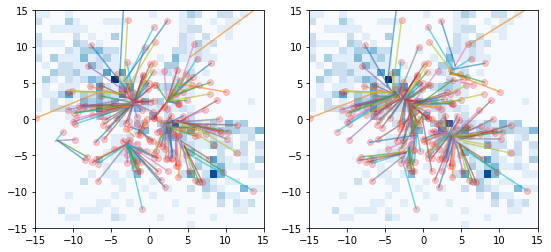

In [85]:
# With prior
fig, axar = plt.subplots(1, 2, figsize=(9, 4))

i=5
ii = 2*i
m = (sy == ii)
rrange = [[-15, 15],[-15, 15]]
bins = 30


ax = axar[0]
ax.hist2d(sx[:,0][m], sx[:,1][m],
                    bins=bins, range=rrange, normed=True, cmap='Blues') ;
ax.plot([xinit[i][:200,0],xfins[i][:200,0]], 
     [xinit[i][:200,1],xfins[i][:200,1]],alpha=0.6);

ax.scatter(xinit[i][:200,0], xinit[i][:200,1],alpha=0.2, color='r');


ax = axar[1]
ax.hist2d(sx[:,0][m], sx[:,1][m],
                    bins=bins, range=rrange, normed=True, cmap='Blues') ;
ax.plot([xinitspec[i][:200,0],xfinsspec[i][:200,0]], 
     [xinitspec[i][:200,1],xfinsspec[i][:200,1]],alpha=0.6);

ax.scatter(xinitspec[i][:200,0], xinitspec[i][:200,1],alpha=0.2, color='r');

# From samples generated by the learned networks

In [ ]:
# tf.reset_default_graph()
# modname = './modules/specdensemodule/'
# xfinsspec = []
# losses = []
# xinitspec = []

# for i in range(6):
#     ii = 2*i
#     seed(100)
#     yy = ii* ones((512)).astype('float32')
#     xi = 5*randn(512,2)
#     xi = xi.astype('float32')
#     recons = dorecon(yy, xi, modname, useprior=True, niter=4000, lr=0.01)
#     xfin = np.squeeze(recons[0])
#     xfinsspec.append(xfin)
#     losses.append(np.squeeze(recons[1]))
#     priors.append(np.squeeze(recons[2]))
#     xinitspec.append(xi)

